In [1]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm

Dataset: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation.

Download and unzip in ./data folder.

In [2]:
# ----------- Configuration -----------
IMG_SIZE = 128
VOLUME_START_AT = 60
VOLUME_SLICES = 75
DATA_PATH = "./data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
SAVE_DIR = "./data"

In [4]:
# ----------- Get patient IDs -----------
# samples = [s for s in os.listdir(DATA_PATH) if "BraTS20" in s]
samples = [
    s for s in os.listdir(DATA_PATH)
    if "BraTS20" in s and s != "BraTS20_Training_355"
]
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

In [5]:
print(f"Train: {len(samples_train)} | Val: {len(samples_val)} | Test: {len(samples_test)}")

Train: 249 | Val: 74 | Test: 45


In [6]:
def get_foreground_crop_coords(img, margin=5):
    """Return crop coordinates [y1, y2, x1, x2] that trim black borders."""
    if np.max(img) == 0:
        return 0, img.shape[0], 0, img.shape[1]

    img_bin = img > 0
    coords = cv2.findNonZero(img_bin.astype(np.uint8))
    x, y, w, h = cv2.boundingRect(coords)
    x1 = max(x - margin, 0)
    y1 = max(y - margin, 0)
    x2 = min(x + w + margin, img.shape[1])
    y2 = min(y + h + margin, img.shape[0])
    return y1, y2, x1, x2


def pad_to_square(img):
    """Pads a 2D array to make it square."""
    h, w = img.shape
    if h == w:
        return img
    diff = abs(h - w)
    if h > w:
        pad_left = diff // 2
        pad_right = diff - pad_left
        padding = ((0, 0), (pad_left, pad_right))
    else:
        pad_top = diff // 2
        pad_bottom = diff - pad_top
        padding = ((pad_top, pad_bottom), (0, 0))
    return np.pad(img, padding, mode='constant', constant_values=0)


def get_largest_tumor_slice(seg, axis):
    """Return index of slice with the largest tumor area along the given axis."""
    max_area = -1
    best_idx = 0
    for i in range(seg.shape[axis]):
        if axis == 0:
            slice_ = seg[i, :, :]
        elif axis == 1:
            slice_ = seg[:, i, :]
        else:  # axis == 2
            slice_ = seg[:, :, i]
        area = np.sum(slice_ > 0)
        if area > max_area:
            max_area = area
            best_idx = i
    return best_idx


def process_samples(sample_list, plot_example=False, use_cropping=False):
    X_all = []
    y_all = []

    num_healthy_patients = 0

    for i, pid in enumerate(tqdm(sample_list)):
        prefix = os.path.join(DATA_PATH, pid, pid)
        flair = nib.load(prefix + "_flair.nii").get_fdata()
        t1ce = nib.load(prefix + "_t1ce.nii").get_fdata()
        t2 = nib.load(prefix + "_t2.nii").get_fdata()
        seg = nib.load(prefix + "_seg.nii").get_fdata()


        axial_idx = get_largest_tumor_slice(seg, axis=2)
        coronal_idx = get_largest_tumor_slice(seg, axis=1)
        sagittal_idx = get_largest_tumor_slice(seg, axis=0)

        views = [
            flair[:, :, axial_idx], flair[:, coronal_idx, :], flair[sagittal_idx, :, :]
        ]
        t1ce_views = [
            t1ce[:, :, axial_idx], t1ce[:, coronal_idx, :], t1ce[sagittal_idx, :, :]
        ]
        t2_views = [
            t2[:, :, axial_idx], t2[:, coronal_idx, :], t2[sagittal_idx, :, :]
        ]
        seg_views = [
            seg[:, :, axial_idx], seg[:, coronal_idx, :], seg[sagittal_idx, :, :]
        ]

        for v in range(3):
            # --- Crop
            if use_cropping:
                y1, y2, x1, x2 = get_foreground_crop_coords(views[v])
                flair_crop = views[v][y1:y2, x1:x2]
                t1ce_crop = t1ce_views[v][y1:y2, x1:x2]
                t2_crop = t2_views[v][y1:y2, x1:x2]
                seg_crop = seg_views[v][y1:y2, x1:x2]
            else:
                flair_crop = views[v]
                t1ce_crop = t1ce_views[v]
                t2_crop = t2_views[v]
                seg_crop = seg_views[v]

            # --- Pad to square
            flair_crop = pad_to_square(flair_crop)
            t1ce_crop = pad_to_square(t1ce_crop)
            t2_crop = pad_to_square(t2_crop)
            seg_crop = pad_to_square(seg_crop)

            # --- Resize
            flair_resized = cv2.resize(flair_crop, (IMG_SIZE, IMG_SIZE))
            t1ce_resized = cv2.resize(t1ce_crop, (IMG_SIZE, IMG_SIZE))
            t2_resized = cv2.resize(t2_crop, (IMG_SIZE, IMG_SIZE))
            seg_resized = cv2.resize(seg_crop, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

            seg_resized[seg_resized == 4] = 3

            if np.all(seg_resized == 0):
                num_healthy_patients += 1
                continue

            x = np.stack([flair_resized, t1ce_resized, t2_resized], axis=0)
            x_max = np.max(x)
            x = x / x_max if x_max > 0 else x

            X_all.append(torch.tensor(x, dtype=torch.float32))
            y_all.append(torch.tensor(seg_resized, dtype=torch.long))

            if i == 0 and v == 0 and plot_example:
                fig, axs = plt.subplots(3, 3, figsize=(15, 10))  # 3 rows: original, cropped, resized

                # First row: original (uncropped)
                axs[0, 0].imshow(views[v], cmap='gray')
                axs[0, 0].set_title('Original FLAIR')
                axs[0, 1].imshow(t1ce_views[v], cmap='gray')
                axs[0, 1].set_title('Original T1CE')
                axs[0, 2].imshow(t2_views[v], cmap='gray')
                axs[0, 2].set_title('Original T2')

                # Second row: cropped
                axs[1, 0].imshow(flair_crop, cmap='gray')
                axs[1, 0].set_title('Cropped FLAIR')
                axs[1, 1].imshow(t1ce_crop, cmap='gray')
                axs[1, 1].set_title('Cropped T1CE')
                axs[1, 2].imshow(t2_crop, cmap='gray')
                axs[1, 2].set_title('Cropped T2')

                # Third row: resized
                axs[2, 0].imshow(flair_resized, cmap='gray')
                axs[2, 0].set_title(f'Resized FLAIR ({IMG_SIZE}x{IMG_SIZE})')
                axs[2, 1].imshow(t1ce_resized, cmap='gray')
                axs[2, 1].set_title(f'Resized T1CE ({IMG_SIZE}x{IMG_SIZE})')
                axs[2, 2].imshow(t2_resized, cmap='gray')
                axs[2, 2].set_title(f'Resized T2 ({IMG_SIZE}x{IMG_SIZE})')

                for row in axs:
                    for ax in row:
                        ax.axis('off')
                plt.tight_layout()
                plt.show()

                fig, axs = plt.subplots(1, 5, figsize=(20, 4))
                class_labels = ['All', 'Class 0 (NT)', 'Class 1 (NCR/NET)', 'Class 2 (ED)', 'Class 3 (ET)']
                axs[0].imshow(seg_resized, cmap='tab10')
                axs[0].set_title(class_labels[0])
                for k in range(4):
                    mask = np.where(seg_resized == k, k, np.nan)
                    axs[k + 1].imshow(mask, cmap='tab10', vmin=0, vmax=3)
                    axs[k + 1].set_title(class_labels[k + 1])
                for ax in axs: ax.axis('off')
                plt.tight_layout()
                plt.show()

    print(f"Number of healthy patients: {num_healthy_patients} out of {len(sample_list)}")

    return torch.stack(X_all), torch.stack(y_all)

  0%|          | 0/249 [00:00<?, ?it/s]

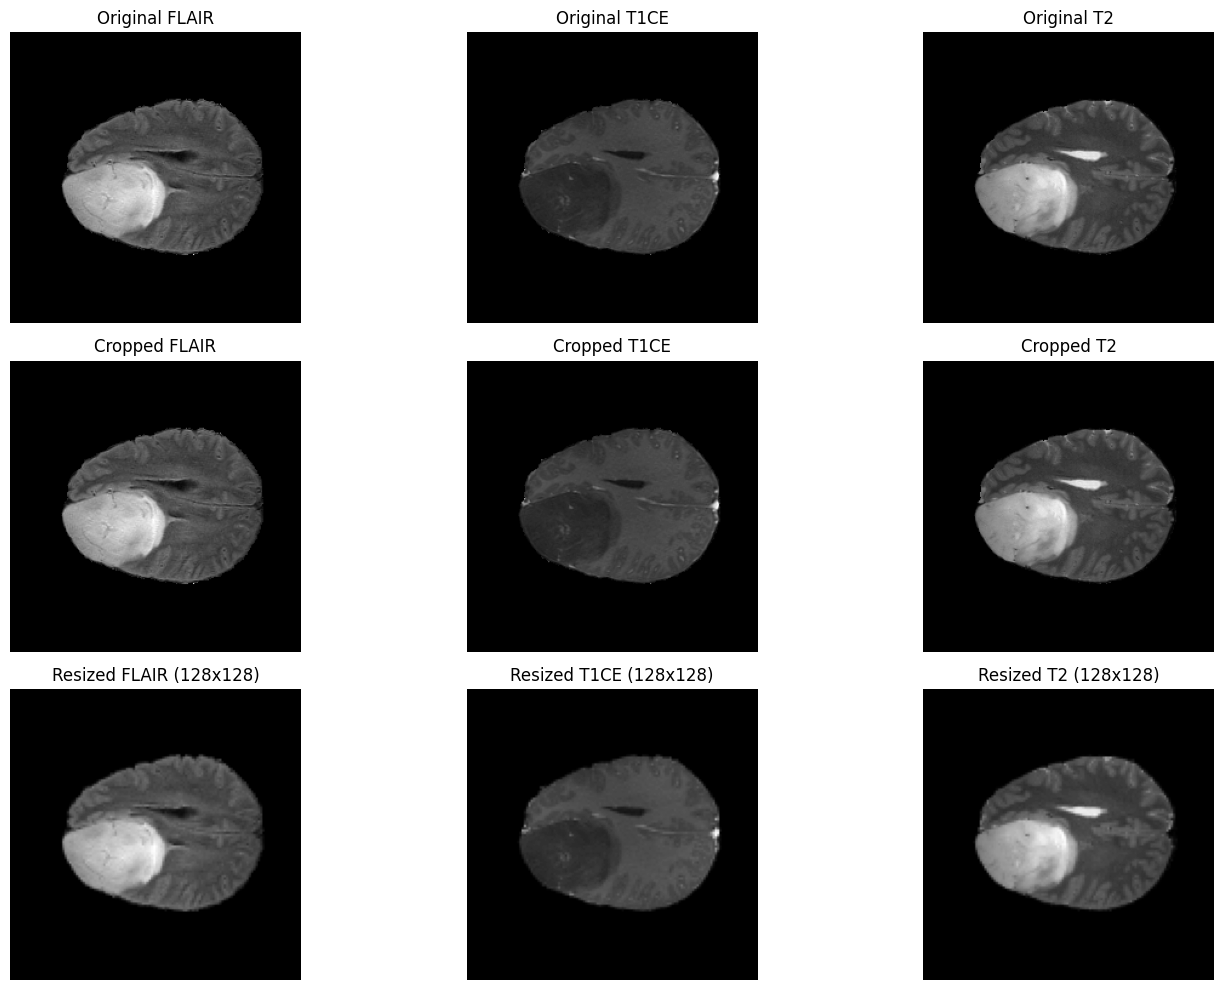

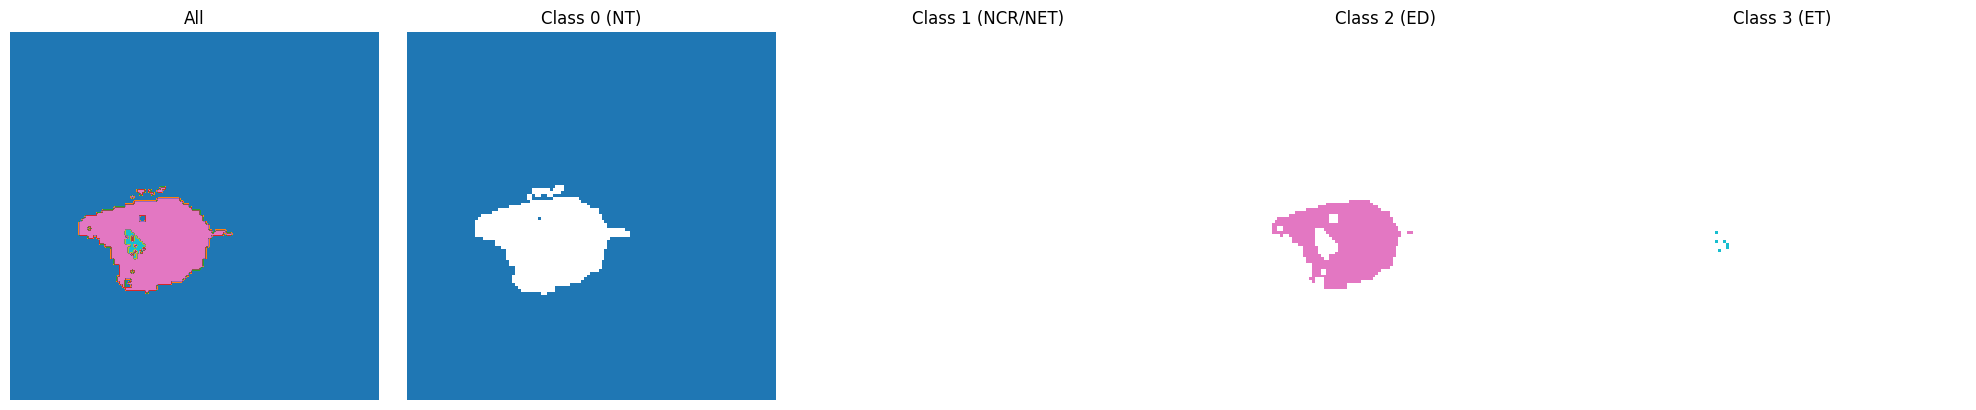

100%|██████████| 249/249 [01:28<00:00,  2.82it/s]


Number of healthy patients: 0 out of 249
Total patients in training: 249
Expected number of slices: 747
Actual number of slices: 747


  0%|          | 0/74 [00:00<?, ?it/s]

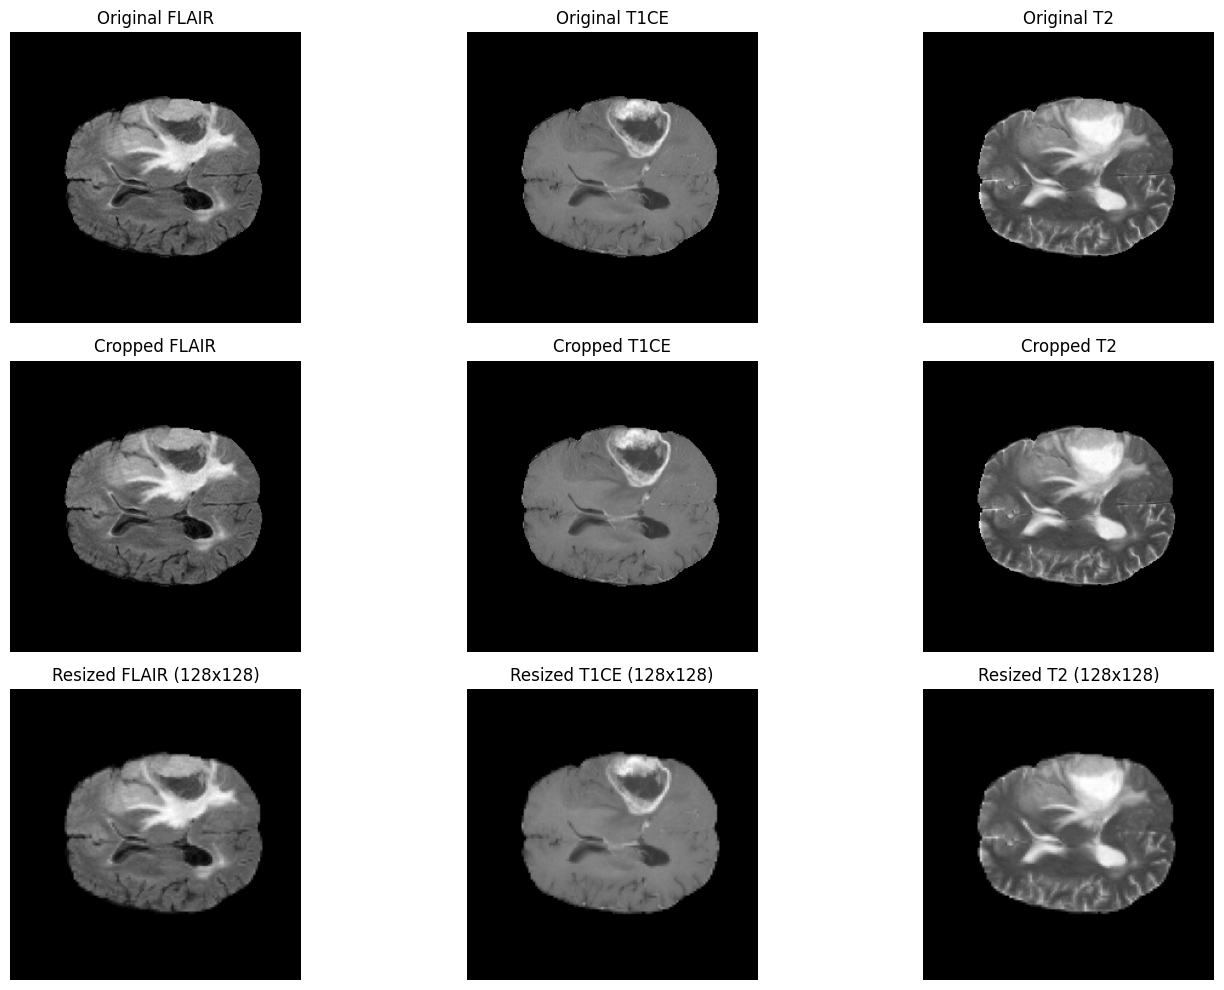

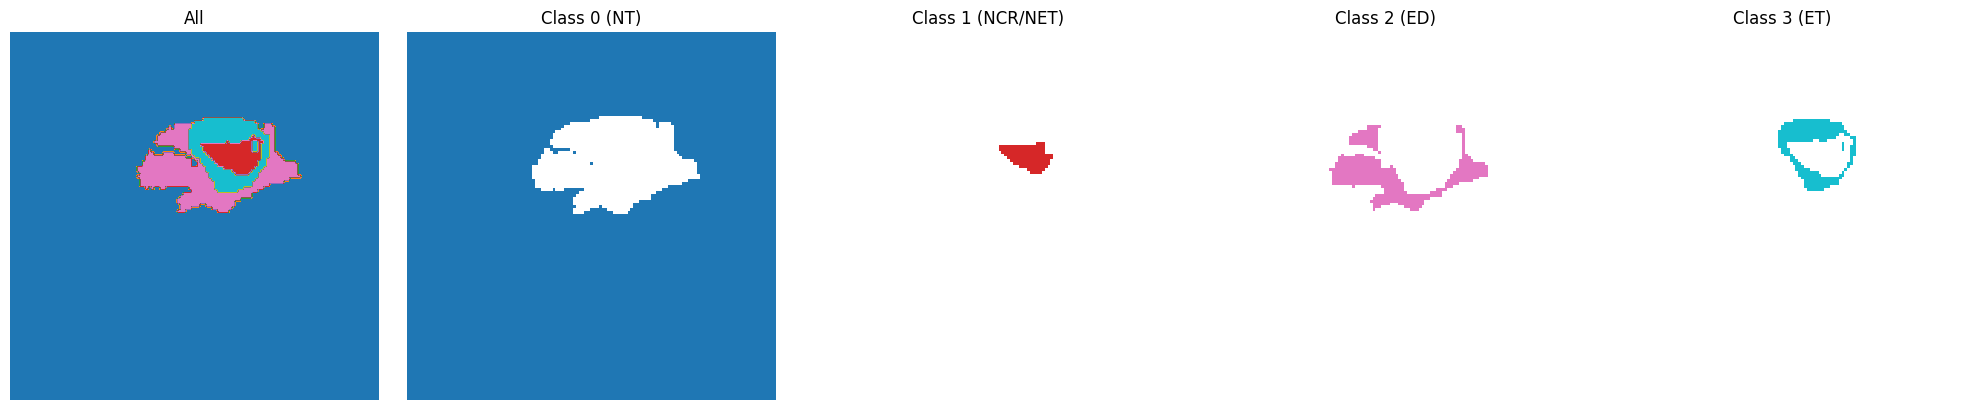

100%|██████████| 74/74 [00:29<00:00,  2.51it/s]


Number of healthy patients: 0 out of 74


  0%|          | 0/45 [00:00<?, ?it/s]

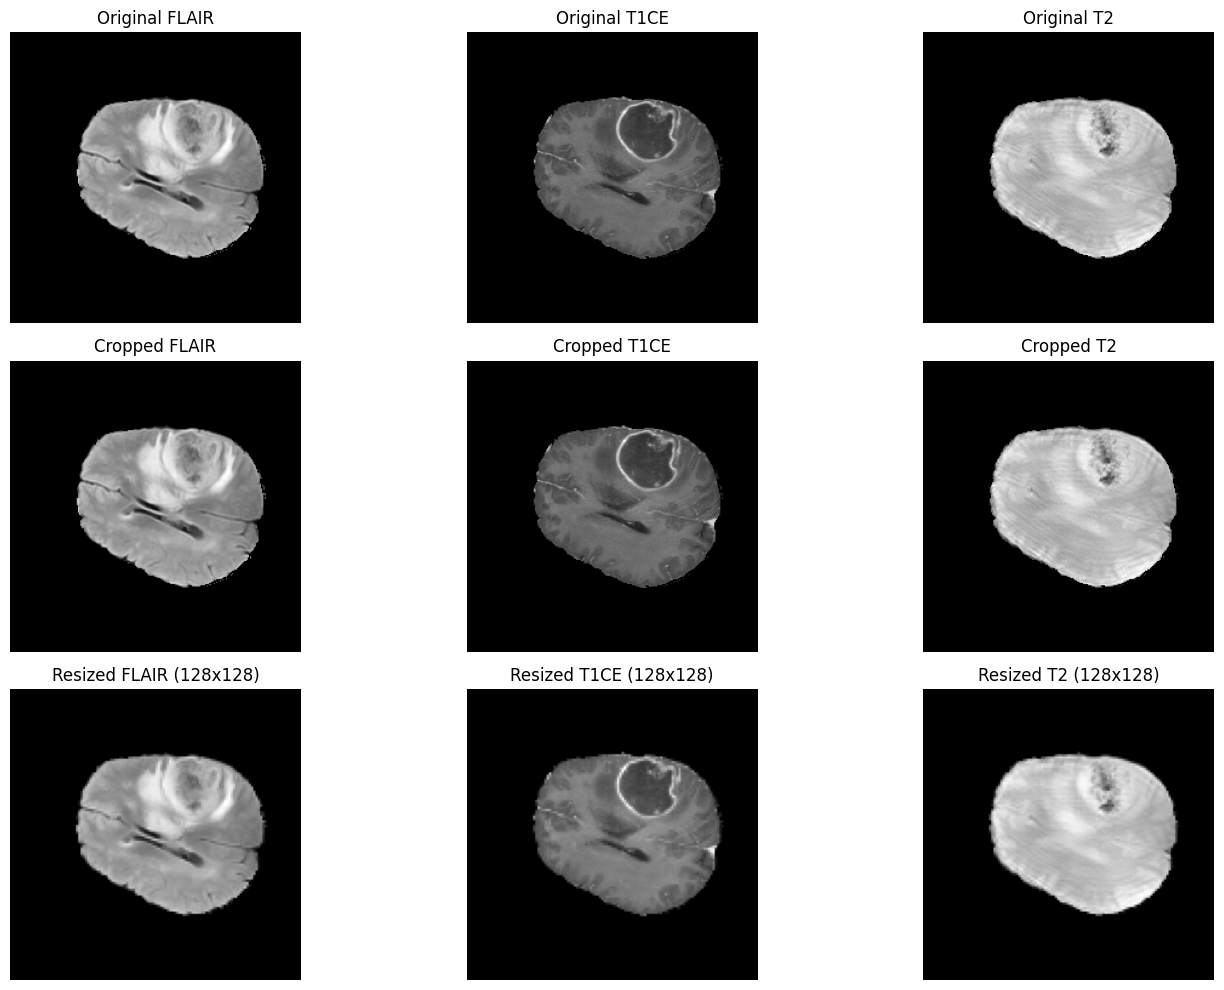

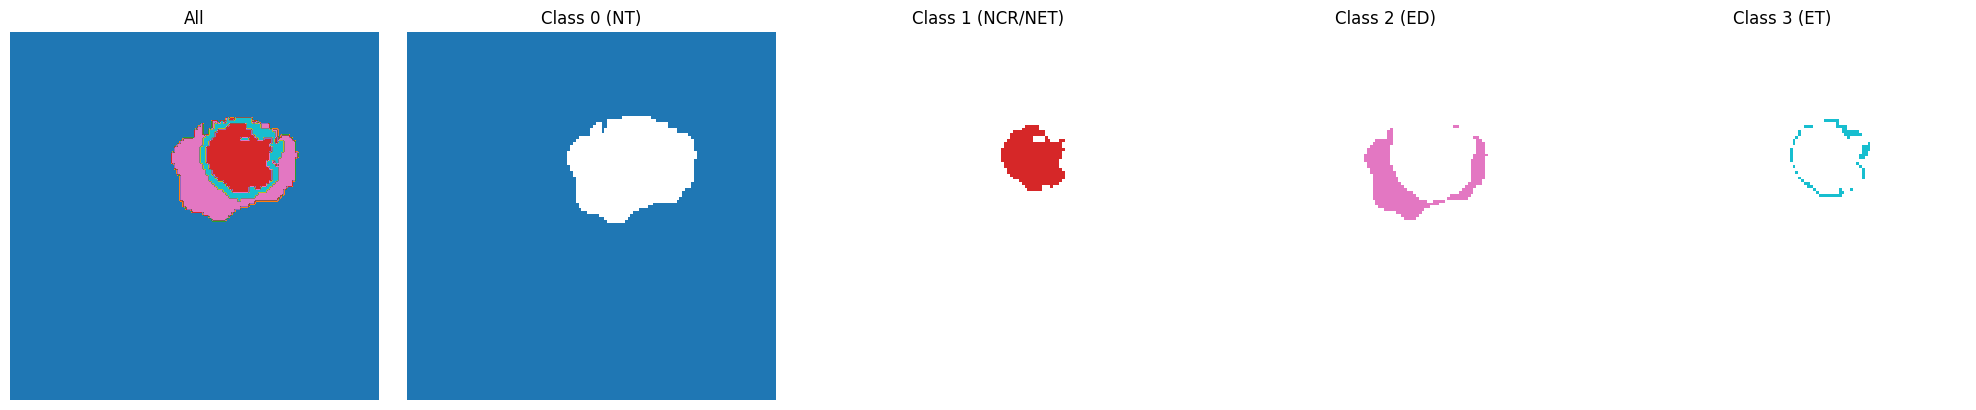

100%|██████████| 45/45 [00:20<00:00,  2.15it/s]


Number of healthy patients: 0 out of 45


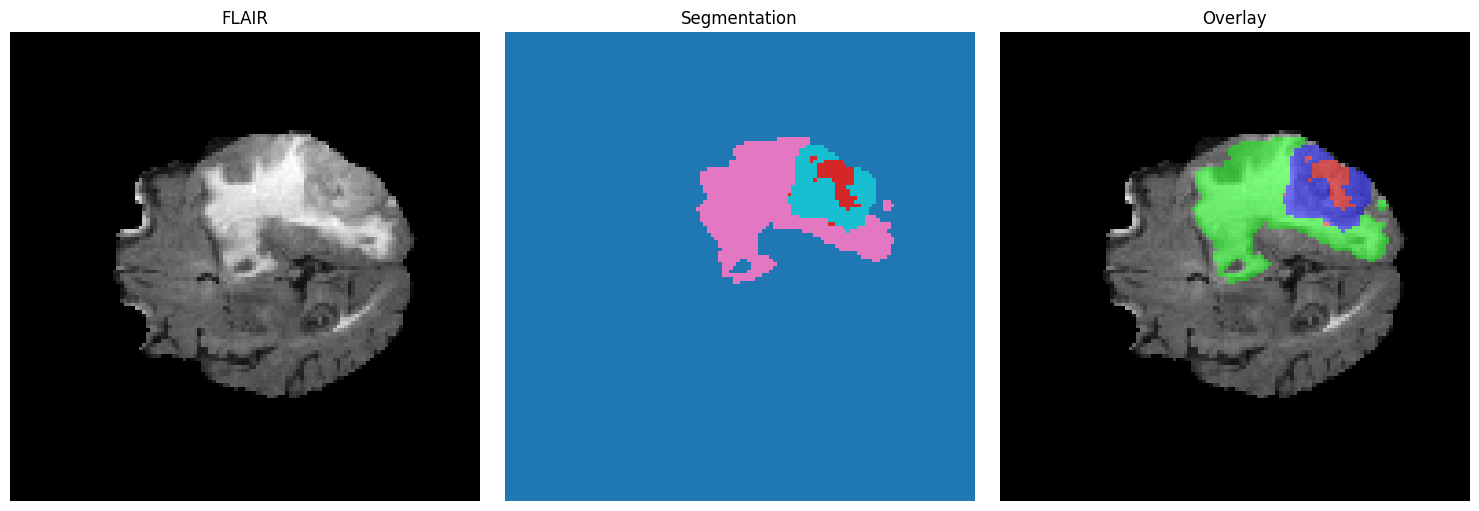

In [7]:
# ----------- Process and save datasets -----------
random.shuffle(samples_train)
X_train, y_train = process_samples(samples_train, plot_example=True, use_cropping=False)

# Just to check the number of slices
print("Total patients in training:", len(samples_train))
print("Expected number of slices:", len(samples_train) * 3)
print("Actual number of slices:", len(X_train))
assert len(X_train) == len(samples_train) * 3, "Mismatch: more or fewer slices than expected!"

X_val, y_val = process_samples(samples_val, plot_example=True, use_cropping=False)
X_test, y_test = process_samples(samples_test, plot_example=True, use_cropping=False)

def test_segmentation_alignment(x_tensor, y_tensor, slice_index=0, alpha=0.5):
    """
    Visual test to check that the segmentation mask aligns with the image.
    x_tensor: Tensor of shape (N, C=3, H, W)
    y_tensor: Tensor of shape (N, H, W)
    """
    import matplotlib.pyplot as plt

    img = x_tensor[slice_index].numpy()
    mask = y_tensor[slice_index].numpy()

    flair = img[0]  # (H, W)
    seg = mask      # (H, W)

    # Normalize FLAIR for display
    flair_norm = (flair - flair.min()) / (flair.max() - flair.min() + 1e-5)
    flair_rgb = np.stack([flair_norm]*3, axis=-1)

    # Create colored mask overlay
    overlay = flair_rgb.copy()
    overlay[seg == 1] = [1.0, 0.0, 0.0]  # Red for NCR/NET
    overlay[seg == 2] = [0.0, 1.0, 0.0]  # Green for ED
    overlay[seg == 3] = [0.0, 0.0, 1.0]  # Blue for ET
    blended = (1 - alpha) * flair_rgb + alpha * overlay

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(flair, cmap='gray')
    axs[0].set_title('FLAIR')
    axs[1].imshow(seg, cmap='tab10', vmin=0, vmax=3)
    axs[1].set_title('Segmentation')
    axs[2].imshow(blended)
    axs[2].set_title('Overlay')
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


test_segmentation_alignment(X_train, y_train, slice_index=123)

In [10]:
os.makedirs(SAVE_DIR, exist_ok=True)
torch.save((X_train, y_train), os.path.join(SAVE_DIR, "brats_train.pt"))
torch.save((X_val, y_val), os.path.join(SAVE_DIR, "brats_val.pt"))
torch.save((X_test, y_test), os.path.join(SAVE_DIR, "brats_test.pt"))

In [11]:
X_train, y_train = torch.load("./data/brats_train.pt")
print(X_train.shape)  
print(y_train.shape)  
print(X_train[0].shape, y_train[0].shape)

torch.Size([747, 3, 128, 128])
torch.Size([747, 128, 128])
torch.Size([3, 128, 128]) torch.Size([128, 128])
